# <center>Inteligencia Artificial</center>
#### <center>Profesor: Dr. Hernán D. Merlino </center>


## <center>Trabajo Práctico:</center>
### <center>  Generar chistes</center>


#### **Integrante:**

* Brayan Ricaldi

## Explicacion previa:

Utilizare el tipo de dato Arrow y no Pandas. Por los siguientes motivos:
   - Arrow esta diseñado para el procesamiento de datos de alto rendimiento y representa  cada conjunto de datos similar a una tabla con un formato en columna de memoria.
   - Permite multiplces procesos sin mover ni copiar los datos, estoo hace que iterar los datos sea realmente rapido.
   
Por estos motivos he podido crear mi modelo y estudiarlo, sin problemas de memoria.<br>
Para mas detalles: https://huggingface.co/course/chapter5/4?fw=pt.

Team Arrow!!

In [1]:
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

2023-03-06 10:45:04.650977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Descargando los datos

<p>Para este modelo usare 2 conjuntos de datos y los voy a concatenar.</p>
<p>Fuentes:</p>
<ul>
    <li><b>ds_1</b>: https://www.kaggle.com/datasets/abhinavmoudgil95/short-jokes?resource=download</li>
    <li><b>ds_2</b>: https://www.kaggle.com/datasets/averkij/reddit-jokes-dataset </li>
</ul>

In [2]:
from datasets import load_dataset

In [3]:
ds_1 = load_dataset(
                    "csv",
                    data_files="./DataSets/shortjokes.csv",
                    split="train"
                    )
ds_1

Using custom data configuration default-9313eabec7887a97
Found cached dataset csv (/home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


Dataset({
    features: ['ID', 'Joke'],
    num_rows: 231657
})

In [4]:
#Formato usado: Apache Arrow
muestra = ds_1.shuffle(seed=0).select(range(2))

for i in muestra:
    print(f"\n>>> ID: {i['ID']}")
    print(f">>> Joke: {i['Joke']}")

Loading cached shuffled indices for dataset at /home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-751734f7ad0b3d4e.arrow



>>> ID: 133560
>>> Joke: I'm not John Madden, just John Disappointeden.

>>> ID: 229327
>>> Joke: Scientists have recently discovered the existence of a mentally unstable microscopic parasite on the moon... Apparently it's a real lunatic


In [5]:
ds_2 = load_dataset(
                    "json", 
                    data_files="./DataSets/reddit_jokes.json", 
                    split="train"
                    )
ds_2

Using custom data configuration default-1c4bc933cdb5722b
Found cached dataset json (/home/br/.cache/huggingface/datasets/json/default-1c4bc933cdb5722b/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


Dataset({
    features: ['body', 'id', 'score', 'title'],
    num_rows: 194553
})

In [6]:
muestra = ds_2.shuffle(seed=0).select(range(2))

for i in muestra:
    print(f">>> Body: {i['body']}")
    print(f">>> Id: {i['id']}")
    print(f">>> Score: {i['score']}")
    print(f">>> Title: {i['title']}\n")

Loading cached shuffled indices for dataset at /home/br/.cache/huggingface/datasets/json/default-1c4bc933cdb5722b/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-5121b6fde057de41.arrow


>>> Body: A paragraph because hes not quite yet an essay.
>>> Id: 32viwk
>>> Score: 19
>>> Title: What do you call a short Mexican?

>>> Body: The circus has cunning stunts.
>>> Id: 5r6xj3
>>> Score: 1
>>> Title: What's the difference between a circus and a strip club?



Para concatenarlos, debo tener los mismos features en los mismos dataSet

In [7]:
#Elimino los feature id, score, tittle de ds_2
ds_2 = ds_2.remove_columns(["score", "title", "id"])
#Cambio el nombre body por Joke
ds_2 = ds_2.rename_column("body", "Joke")
#Elimino el feature ID de ds_2
ds_1 = ds_1.remove_columns(["ID"])

Ahora los concateno y los reorganizo aleatoriamente

In [8]:
from datasets import concatenate_datasets
ds = concatenate_datasets([ds_1, ds_2])
ds = ds.shuffle(seed=0)
ds

Loading cached shuffled indices for dataset at /home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-ae61964094c340c7.arrow


Dataset({
    features: ['Joke'],
    num_rows: 426210
})

In [9]:
muestra = ds.shuffle(seed=0).select(range(5))

for i in muestra:
    print(f">>> Joke: {i['Joke']}")

Loading cached shuffled indices for dataset at /home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-a7c83b00754b6919.arrow


>>> Joke: The worst part about going to concerts is realizing people you'd otherwise think are freaks actually share your taste in music.
>>> Joke: What does MSG stand for? Mandarin Service Guaranteed.
>>> Joke: because there's something standig in my pants for you!
>>> Joke: Who do ghosts worship? Boo, DUH!!!
>>> Joke: Me


## Estudio del dataSet

Convierto el DataSet a formato pandas, para mejor estudio de los datos y visualizaciones.

In [10]:
import pandas as pd
df = ds.to_pandas()

<p><b>Busco la cantidad de None del dataSet</b></p>

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426210 entries, 0 to 426209
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Joke    426210 non-null  object
dtypes: object(1)
memory usage: 3.3+ MB


Observo que el dataSet no tiene ningun None, en otras palabras no tiene ningun dato faltante.

<p><b>Busco la cantidad de datos repetidos</b></p>

In [12]:
print(f" Cantidad de datos repetidos: {sum(df.duplicated(keep='first'))}")

 Cantidad de datos repetidos: 17723


In [13]:
df.drop_duplicates(inplace=True)

In [14]:
len(df)

408487

<p><b>Estudio la longitud de los chistes</b></p>

Ahora voy a estudiar la longitud de los chistes, el separador sera el espacio(" ").<br>
La longitud de cada chiste se consegira con el dataSet tipo Arrow para optimizar la velocidad y la ram.

In [15]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df, split='train')
ds = ds.remove_columns(["__index_level_0__"])#Cuando pasas de pandas --> Arrow, se crea un feature index
ds

Dataset({
    features: ['Joke'],
    num_rows: 408487
})

In [16]:
def longitud(chiste):
    return {"joke_len": len(chiste["Joke"].split())}

In [17]:
ds = ds.map(longitud)

  0%|          | 0/408487 [00:00<?, ?ex/s]

In [18]:
df = ds.to_pandas()
df.head()

Text(0.5, 1.0, 'Longitud de los chistes')

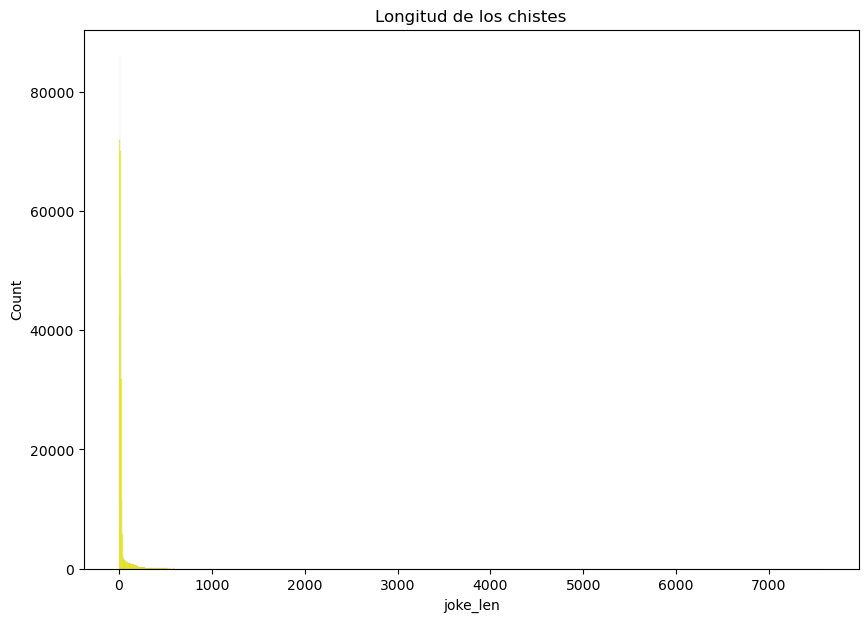

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(10, 7))
sns.histplot(
    x="joke_len",
    data=df,
    binwidth=5,
    color="#ffff00",
)
axes.set_title("Longitud de los chistes")

Observo que hay chistes de longitud menor a 5 y mayor a 1000.

Chistes con longitud menor a 5

In [26]:
longitud_minima_chistes = 5

In [40]:
df[df["joke_len"] < longitud_minima_chistes].head()

,Joke,joke_len
4,,0
12,It goes chew chew..,4
19,.,1
23,Not Ali....,2
26,42.,1


In [46]:
longitud_maxima_chistes =100

In [47]:
df[df["joke_len"] > longitud_maxima_chistes].head()

,Joke,joke_len
1,A blond is done with all the blond jokes. So s...,236
14,and orders a bowl of beer nuts from the barten...,130
25,He has only one question standing between him ...,112
32,Before long they are in the hospital deliverin...,131
64,"The old man looks at him and says, ""Lad, look ...",169


Estudio la cantidad de estos chistes, para ver si los puedo eliminar.
Mis argumento para eliminarlos, seria que los chistes muy cortos y muy largos

In [48]:
chistes_menores_cinco = df[df["joke_len"] < longitud_minima_chistes].shape[0]
chistes_mayores_cien = df[df["joke_len"] > longitud_maxima_chistes].shape[0]
chistes_total = df.shape[0]
print(f"Porcentaje del total de chistes menores a 5: {(100 * chistes_menores_cinco) / chistes_total}%")
print(f"Porcentaje del total de chistes mayores a 100: {(100 * chistes_mayores_cien) / chistes_total}%")

Porcentaje del total de chistes menores a 5: 10.410123210775373%
Porcentaje del total de chistes mayores a 100: 5.4667590400673705%


<p>Observo que si los elimino perderia un 15% de mi dataSet.</p>
<p>Pasare a elimininarlos, mi justificacion sera.</p>
<ul>
    <li><b>Chistes menores a 5:</b> Al ser chistes muy cortos no tienen un sentido de gracia muy definido, son entendidos ccon un contexto dado(que en este caso no los tenemos).</li>
    <li><b>Chistes mayores a 100:</b> Son chistes, no explicaciones de fisica.</li>
</ul>

In [49]:
ds = ds.filter(lambda x: x["joke_len"] >= longitud_minima_chistes)
ds = ds.filter(lambda x: x["joke_len"] <= longitud_maxima_chistes)

  0%|          | 0/409 [00:00<?, ?ba/s]

  0%|          | 0/366 [00:00<?, ?ba/s]

In [50]:
ds

Dataset({
    features: ['Joke', 'joke_len'],
    num_rows: 343632
})

Grafico nuevamente para ver la longitud de los chistes.

Text(0.5, 1.0, 'Longitud de los chistes')

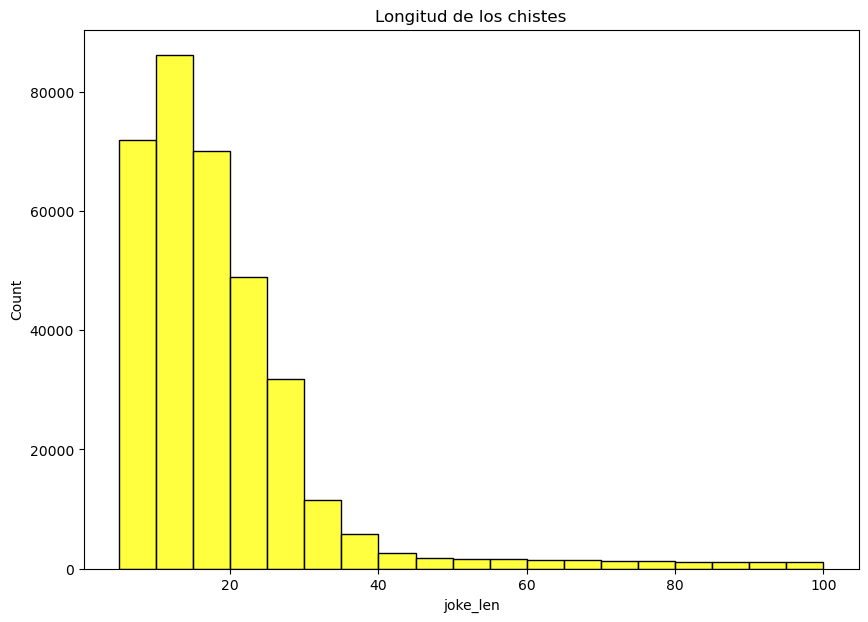

In [53]:
df = ds.to_pandas()
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(10, 7))
sns.histplot(
    x="joke_len",
    data=df,
    binwidth=5,
    color="#ffff00",
)
axes.set_title("Longitud de los chistes")

## Preparando los dataSet

Elimino el feature ID porque no brinda informacion

In [54]:
ds = ds.remove_columns(["joke_len"])
ds

Dataset({
    features: ['Joke'],
    num_rows: 343632
})

Cambio el nombre del feature "Joke" por "joke", por comodidad

In [55]:
ds = ds.rename_column("Joke", "joke")
ds

Dataset({
    features: ['joke'],
    num_rows: 343632
})

Elimino las etiquetas HTML de los chistes

In [56]:
import html
ds = ds.map(lambda x: {"joke": html.unescape(x["joke"])})
ds

  0%|          | 0/343632 [00:00<?, ?ex/s]

Dataset({
    features: ['joke'],
    num_rows: 343632
})

## Dividio el dataSet en train y test

Divido el dataSet en 2:
   - Train: 70%.
   - Test: 30%. <br>

Para division sera de forma aleatoria con el parametro shuffle=True.

In [57]:
ds_joke = ds.train_test_split(
                                test_size=0.3, 
                                shuffle=True,
                                seed=1
                            )

In [58]:
ds_joke

DatasetDict({
    train: Dataset({
        features: ['joke'],
        num_rows: 240542
    })
    test: Dataset({
        features: ['joke'],
        num_rows: 103090
    })
})

# Modelo

## Tokenizacion

In [59]:
from transformers import AutoTokenizer

La longitud de los contextos sera de 128, por temas de optimizar la memoria.<br>
Si tiene una memoria mayor y un cpu potente lo puede cambiar por 1024 o 2048.

In [68]:
context_length = 128

Longitud del contexto: Cantidad de tokens que debe tener la oracion. <br>
#Importante: AGREGAR IMAGEN DE EXPLICACION.

Descargo un tokenizador ya entrenado.<br>
Cada token ya tiene establecido su propio ID <br>
#IMPORTANTE: AGREGAR IMAGEN EXPLICANDO ESTE PROCESO

In [71]:
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

In [72]:
def tokenize_function(examples):
    outputs = tokenizer(
        examples["joke"], 
        truncation=False,#True
        return_overflowing_tokens=True,
        return_length=True,
        add_special_tokens=True,
        max_length=context_length,
    )
    
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        input_batch.append(input_ids + [tokenizer.eos_token_id])
        #if length == 15:
        #input_batch.append(input_ids)
    return {"input_ids": input_batch}



# Use batched=True to activate fast multithreading!
tokenized_datasets = ds_joke.map(
    tokenize_function, batched=True, remove_columns=ds_joke["train"].column_names)
tokenized_datasets

  0%|          | 0/241 [00:00<?, ?ba/s]

  0%|          | 0/104 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 240542
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 103090
    })
})

Voy a estudiar la longitud de los tokens.

Imprimo la cantidad de tokens de los 15 1eros chistes.

In [79]:
tokenized_samples = tokenized_datasets["train"][:15]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 22'
'>>> Review 1 length: 18'
'>>> Review 2 length: 27'
'>>> Review 3 length: 18'
'>>> Review 4 length: 31'
'>>> Review 5 length: 24'
'>>> Review 6 length: 146'
'>>> Review 7 length: 15'
'>>> Review 8 length: 16'
'>>> Review 9 length: 14'
'>>> Review 10 length: 18'
'>>> Review 11 length: 40'
'>>> Review 12 length: 19'
'>>> Review 13 length: 11'
'>>> Review 14 length: 52'


Como se menciono anteriormente, voy a trabajar con un contexto de 128 tokens, asi que debo hacer que cada chiste tenga 128 tokens ni mas ni menos.<br>
Pero eso es un problema, ya que estamos observando que los 1eros 15 chistes estan compuestos por menos de 65 tokens.<br>

<h3><b>¿Que se podra hacer? </b></h3>
<p>Tenemos 4 posibles soluciones:<p>
<ol>
   <li> Solo quedarnos con los chistes formados por 128 tokens.</li>
   <li> Solo quedarnos con los chistes mayores o igual a 128 tokens, y luego truncar su valores(solo quedarme con los 1ero 128 tokens).</li>
   <li> Modificiar la longitud del contexto, un valor menor como ya vimos que los 1eros 15 chistes son de una longitud muy menor a 128, podemos cambiar el contexto a 20.
   <li> Concatenar todos los chistes y luego dividirlo en segmentos de 128 tokens.
</ol>
<p><b>Problemas:</b></p>
<ul>
    <li> Las soluciones 1 y 2 no serian las mas convenientes para nuestro problema, ya vimos que los 1eros 15 chistes eran menores a 128 tokens, perderiamos muchos datos al solo quedarme con los chistes largos.
    <li> Con la solucion 3 no perderia datos pero si contexto en los chistes, al solo quedarme con la parte inicial los chistes perderian significado.
    <li> La solucion 4 es la mejor. Ahora se explicara el <b>porque</b>.
</ul>


#IMPORTANTE: COMPLETAR <br>
Explicacion:

In [83]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 471'


In [84]:
chunk_size = context_length

Una forma sencilla seria unir los tokens

In [85]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 87'


<p> Observo que el ultimo dato, tiene 87 tokens. </p>
<p>Tenemos 2 posibles soluciones.</p>
<ol>
    <li> Completar el dato con id que significan "vacio", para Arrow el 0 es el id vacio</li>
    <li> ELiminar el dato</li>
</ol>
<p>En este caso se elegira la opcion 2.</p>

Ahora recreare todo lo hecho con el dataSet completo.

In [86]:
def group_texts(examples):
    # Concateno todo el texto
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Calculo la longitud de los textos concatenados
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Si el ultimo fragmento es mas pequenio que la "longitud del contexto" sera eliminado.
    total_length = (total_length // chunk_size) * chunk_size
    # Hago un split del tamanio de la "longitud del contexto"
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [87]:
df_tokenizado = tokenized_datasets.map(group_texts, batched=True)
df_tokenizado

  0%|          | 0/241 [00:00<?, ?ba/s]

  0%|          | 0/104 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 56095
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 24014
    })
})

<h3>¿Por que la solucion 4 funciona?</h3>

<p>No solo se concatenara los chistes, sino tambien nuestro modelo gpt2(Spolier!) se dara cuenta que cada data no es un solo chiste, sino que pueden ser varios y los tomara por separado</p>
<p><b>Y como se da cuenta cuando termina uno y comienza el siguiente chistes?</b></p>
<p>Por el caracter especial del tokenizador eos_token, que fue agregado cuando tokenizamos en el siguiente codigo:</p>
<ul>
    <li>input_batch.append(input_ids + <b>[tokenizer.eos_token_id]</b>)</li>
</ul>
</p>Su representacion es de la siguiente forma:</p>
<ul>
    <li>>>> Texto: <|endoftext|> </li>
    <li>>>> ID: 0</li>
</ul>

Lo vamos a observar en nuestro 1er dato

In [88]:
tokenizer.decode(df_tokenizado["train"][0]["input_ids"])

'Which US President was least guilty? Lincoln. He was in a cent.<|endoftext|>What are dull needles good for?  Nothing, they\'re pointless.<|endoftext|>Sorry I haven\'t tweeted much. Kathy on facebook was keeping us updated on her menstrual cramps.<|endoftext|>we\'re actually of yo momma because she\'s so damn hairy.<|endoftext|>Wife: "I look fat. Can you give me a compliment?"\nHusband: "You have perfect eyesight." <|endoftext|>I\'m having a hard time deciding which pillow I'

In [89]:
ids = list(df_tokenizado["train"][0]["input_ids"])
i_cero = [i for i, dato in enumerate(ids) if dato == 0]
print(f"Ids del 1er dato: {ids}")
print(f"Posiciones del 0: {i_cero}")

Ids del 1er dato: [29927, 16835, 473, 456, 4613, 1442, 3635, 5752, 326, 839, 31, 35340, 594, 78, 14, 4348, 1442, 253, 231, 2767, 14, 0, 25027, 602, 270, 967, 1503, 1759, 5758, 296, 31, 179, 11170, 12, 2469, 3962, 1248, 2989, 14, 0, 29124, 410, 15824, 1059, 10235, 301, 7421, 14, 2020, 348, 89, 517, 41203, 1442, 14993, 2573, 3282, 517, 22333, 13903, 427, 1031, 243, 291, 15434, 14, 0, 955, 3962, 5364, 311, 22391, 42511, 345, 2676, 12045, 975, 914, 26252, 78, 366, 1293, 459, 14, 0, 55, 4099, 26, 333, 41, 2045, 34250, 14, 4501, 1403, 6276, 434, 231, 824, 45572, 13290, 173, 40, 483, 5512, 26, 333, 6147, 1054, 16852, 262, 6614, 834, 2359, 179, 0, 41, 9991, 7659, 231, 6291, 626, 3822, 39009, 947, 23162, 606, 410]
Posiciones del 0: [21, 39, 66, 84, 115]


Observamos que en nuestro 1er dato hay 5 ceros, en otras palabras hay 4 chistes(no necesariamente el 1er y el ultimo esten completos).

# Modelo

<p>Inicializo un nuevo modelo de GPT2, con las configuracion que estoy usando.</p>
<ul>
    <li> La longitud de contexto en 64.</li>
    <li> La longitud del vocabulario igual al tokenizador. </li>
    <li> La separacion de los chistes con eos_token_id.</li>
</ul>

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = GPT2LMHeadModel(config)

Observo los parametros a entrenar de mi modelo.

In [ ]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parametros")

In [ ]:
#IMPORTANTE: Al tener todas las filas de 128 tokens, no es necesario el recolector de datos!

In [ ]:
from transformers import DataCollatorForLanguageModeling 

tokenizer.pad_token = tokenizer.eos_token 
data_collator = DataCollatorForLanguageModeling(tokenizer, 
                                                mlm= False # True: Si es para un modelo de lenguaje enmascarado  
                                               )

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    #fp16=True, #Importante: SOlo descomentar si tenes GPU
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

In [ ]:
trainer.train()

# Datos 2

In [ ]:
df_2 = load_dataset("json", data_files="./DataSets/reddit_jokes.json", split="train")

In [ ]:
df_2

In [ ]:
df_2[0:4]

In [ ]:
df_2

In [ ]:
df_2 = df_2.remove_columns(["score", "title", "id"])

In [ ]:
df_2[0]

In [ ]:
len(df_2)

In [ ]:
df_2[-1]